In [1]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as tck
from matplotlib import colors

import numpy as np

from scipy.interpolate import interp1d

import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.constants as const

from astropy.cosmology import default_cosmology
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy import constants as const
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from astropy.constants import G, c, M_sun
import astropy.io.fits as pyfits
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util
import emcee
import corner

mpi = False

from lenstronomy.Workflow.fitting_sequence import FittingSequence
import pyswarms as ps
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
import warnings

import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 36}

matplotlib.rc('font', **font)
warnings.filterwarnings('ignore')

In [2]:
z_lens =  0.881
z_source =  2.059
lens_model_list = ['EPL','SHEAR','SIS']



def lens_model_func(main_lens,shear,subhalo):
        
    theta_E,gamma,clx,cly,el1,el2 = main_lens
    gamma1, gamma2 = shear
    
    b_in_1e_3, centerxproj, centeryproj,z_int = subhalo

    ######################Calculating Projectionn
    if z_int < z_lens:
        centerx,centery = centerxproj,centeryproj
    else:
        
        
        kwargs_lens_model_macro = [{'theta_E': theta_E,'gamma':gamma, 'center_x': clx, 'center_y': cly, 'e1': el1, 'e2': el2,},
                             {'gamma1': gamma1, 'gamma2': gamma2}]

        lens_model_list_macro = ['EPL','SHEAR']
        redshifts_macro = [z_lens,z_lens]

        lens_model_class_macro = LensModel(lens_model_list=lens_model_list_macro, z_source=z_source, 
                             lens_redshift_list=redshifts_macro, multi_plane=True)
        sourceplanex,sourceplaney = lens_model_class_macro.ray_shooting(centerxproj, centeryproj, kwargs_lens_model_macro, k=None)
        
        alpha_l = np.array([centerxproj,centeryproj])
        alpha_s = np.array([sourceplanex,sourceplaney])
        chis, chil, chi = cosmo.comoving_distance([z_source,z_lens,z_int])
        
        veca = (chis*alpha_s - chil*alpha_l)/(chis-chil)
        vecb = (alpha_l-alpha_s)*((chis*chil)/(chis-chil))
        
        centercood = veca + (1./chi)*vecb
        centerx,centery = float(centercood[0]),float(centercood[1])
        
        
    kwargs_lens_model = [{'theta_E': theta_E,'gamma':gamma, 'center_x': clx, 'center_y': cly, 'e1': el1, 'e2': el2,},
                         {'gamma1': gamma1, 'gamma2': gamma2},
                         {'theta_E':b_in_1e_3*1e-3, 'center_x': centerx, 'center_y': centery}]
    redshifts_func = [z_lens,z_lens,z_int]
    
    lens_model_class_func = LensModel(lens_model_list=lens_model_list, z_source=z_source, 
                         lens_redshift_list=redshifts_func, multi_plane=True)
        
    return lens_model_class_func, kwargs_lens_model, lens_model_class_macro, kwargs_lens_model_macro


def assignparam(params):
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]

        subhalo = params[8],params[9],params[10],params[11]
        
        lens_model_f,kwargsz,lens_modmac, kwargsmac = lens_model_func(main_lens,shear,subhalo)
        
        return lens_model_f,kwargsz, lens_modmac, kwargsmac

In [3]:
a_good_fit = np.array([ 0.46,  2.30, -0.0,-0.0,-0.03,0.10,
                      -0.01, 0.01,
                      12.5,0.05,0.49,1.40])
            

lens_model, kwargss, lens_mod_mac,kwargsmac = assignparam(a_good_fit)

nres = 4
numpix2 = 50*nres
deltaPix2 = 0.025/nres
ext2 = numpix2*deltaPix2/2. - deltaPix2/2.

x_vals = np.linspace(-ext2,ext2,numpix2)
y_vals = np.linspace(-ext2,ext2,numpix2)

curl_map = np.zeros([numpix2,numpix2])

kappa_map = np.zeros([numpix2,numpix2])

macro_kap_map = np.zeros([numpix2,numpix2])

for i in range(numpix2):
    for j in range(numpix2):
        curl_map[i,j] = lens_model.curl(x_vals[j],y_vals[i],kwargss)
        kappa_map[i,j] = lens_model.kappa(x_vals[j],y_vals[i],kwargss)
        macro_kap_map[i,j] = lens_mod_mac.kappa(x_vals[j],y_vals[i],kwargsmac)

In [4]:
a_good_fit2 = np.array([ 0.46,  2.30, -0.0,-0.0,-0.03,0.10,
                      -0.01, 0.01,
                      12.5,0.05,0.49,1.05])
            

lens_model2, kwargss2, lens_mod_mac2,kwargsmac2 = assignparam(a_good_fit2)

nres = 4
numpix2 = 50*nres
deltaPix2 = 0.025/nres
ext2 = numpix2*deltaPix2/2. - deltaPix2/2.

x_vals = np.linspace(-ext2,ext2,numpix2)
y_vals = np.linspace(-ext2,ext2,numpix2)

curl_map2 = np.zeros([numpix2,numpix2])

kappa_map2 = np.zeros([numpix2,numpix2])

macro_kap_map2 = np.zeros([numpix2,numpix2])

for i in range(numpix2):
    for j in range(numpix2):
        curl_map2[i,j] = lens_model2.curl(x_vals[j],y_vals[i],kwargss2)
        kappa_map2[i,j] = lens_model2.kappa(x_vals[j],y_vals[i],kwargss2)
        macro_kap_map2[i,j] = lens_mod_mac2.kappa(x_vals[j],y_vals[i],kwargsmac2)

In [5]:
a_good_fit3 = np.array([ 0.46,  2.30, -0.0,-0.0,-0.03,0.10,
                      -0.01, 0.01,
                      12.5,0.05,0.49,0.95])
            

lens_model3, kwargss3, lens_mod_mac3,kwargsmac3 = assignparam(a_good_fit3)

nres = 4
numpix2 = 50*nres
deltaPix2 = 0.025/nres
ext2 = numpix2*deltaPix2/2. - deltaPix2/2.

x_vals = np.linspace(-ext2,ext2,numpix2)
y_vals = np.linspace(-ext2,ext2,numpix2)

curl_map3 = np.zeros([numpix2,numpix2])

kappa_map3 = np.zeros([numpix2,numpix2])

macro_kap_map3 = np.zeros([numpix2,numpix2])

for i in range(numpix2):
    for j in range(numpix2):
        curl_map3[i,j] = lens_model3.curl(x_vals[j],y_vals[i],kwargss3)
        kappa_map3[i,j] = lens_model3.kappa(x_vals[j],y_vals[i],kwargss3)
        macro_kap_map3[i,j] = lens_mod_mac3.kappa(x_vals[j],y_vals[i],kwargsmac3)

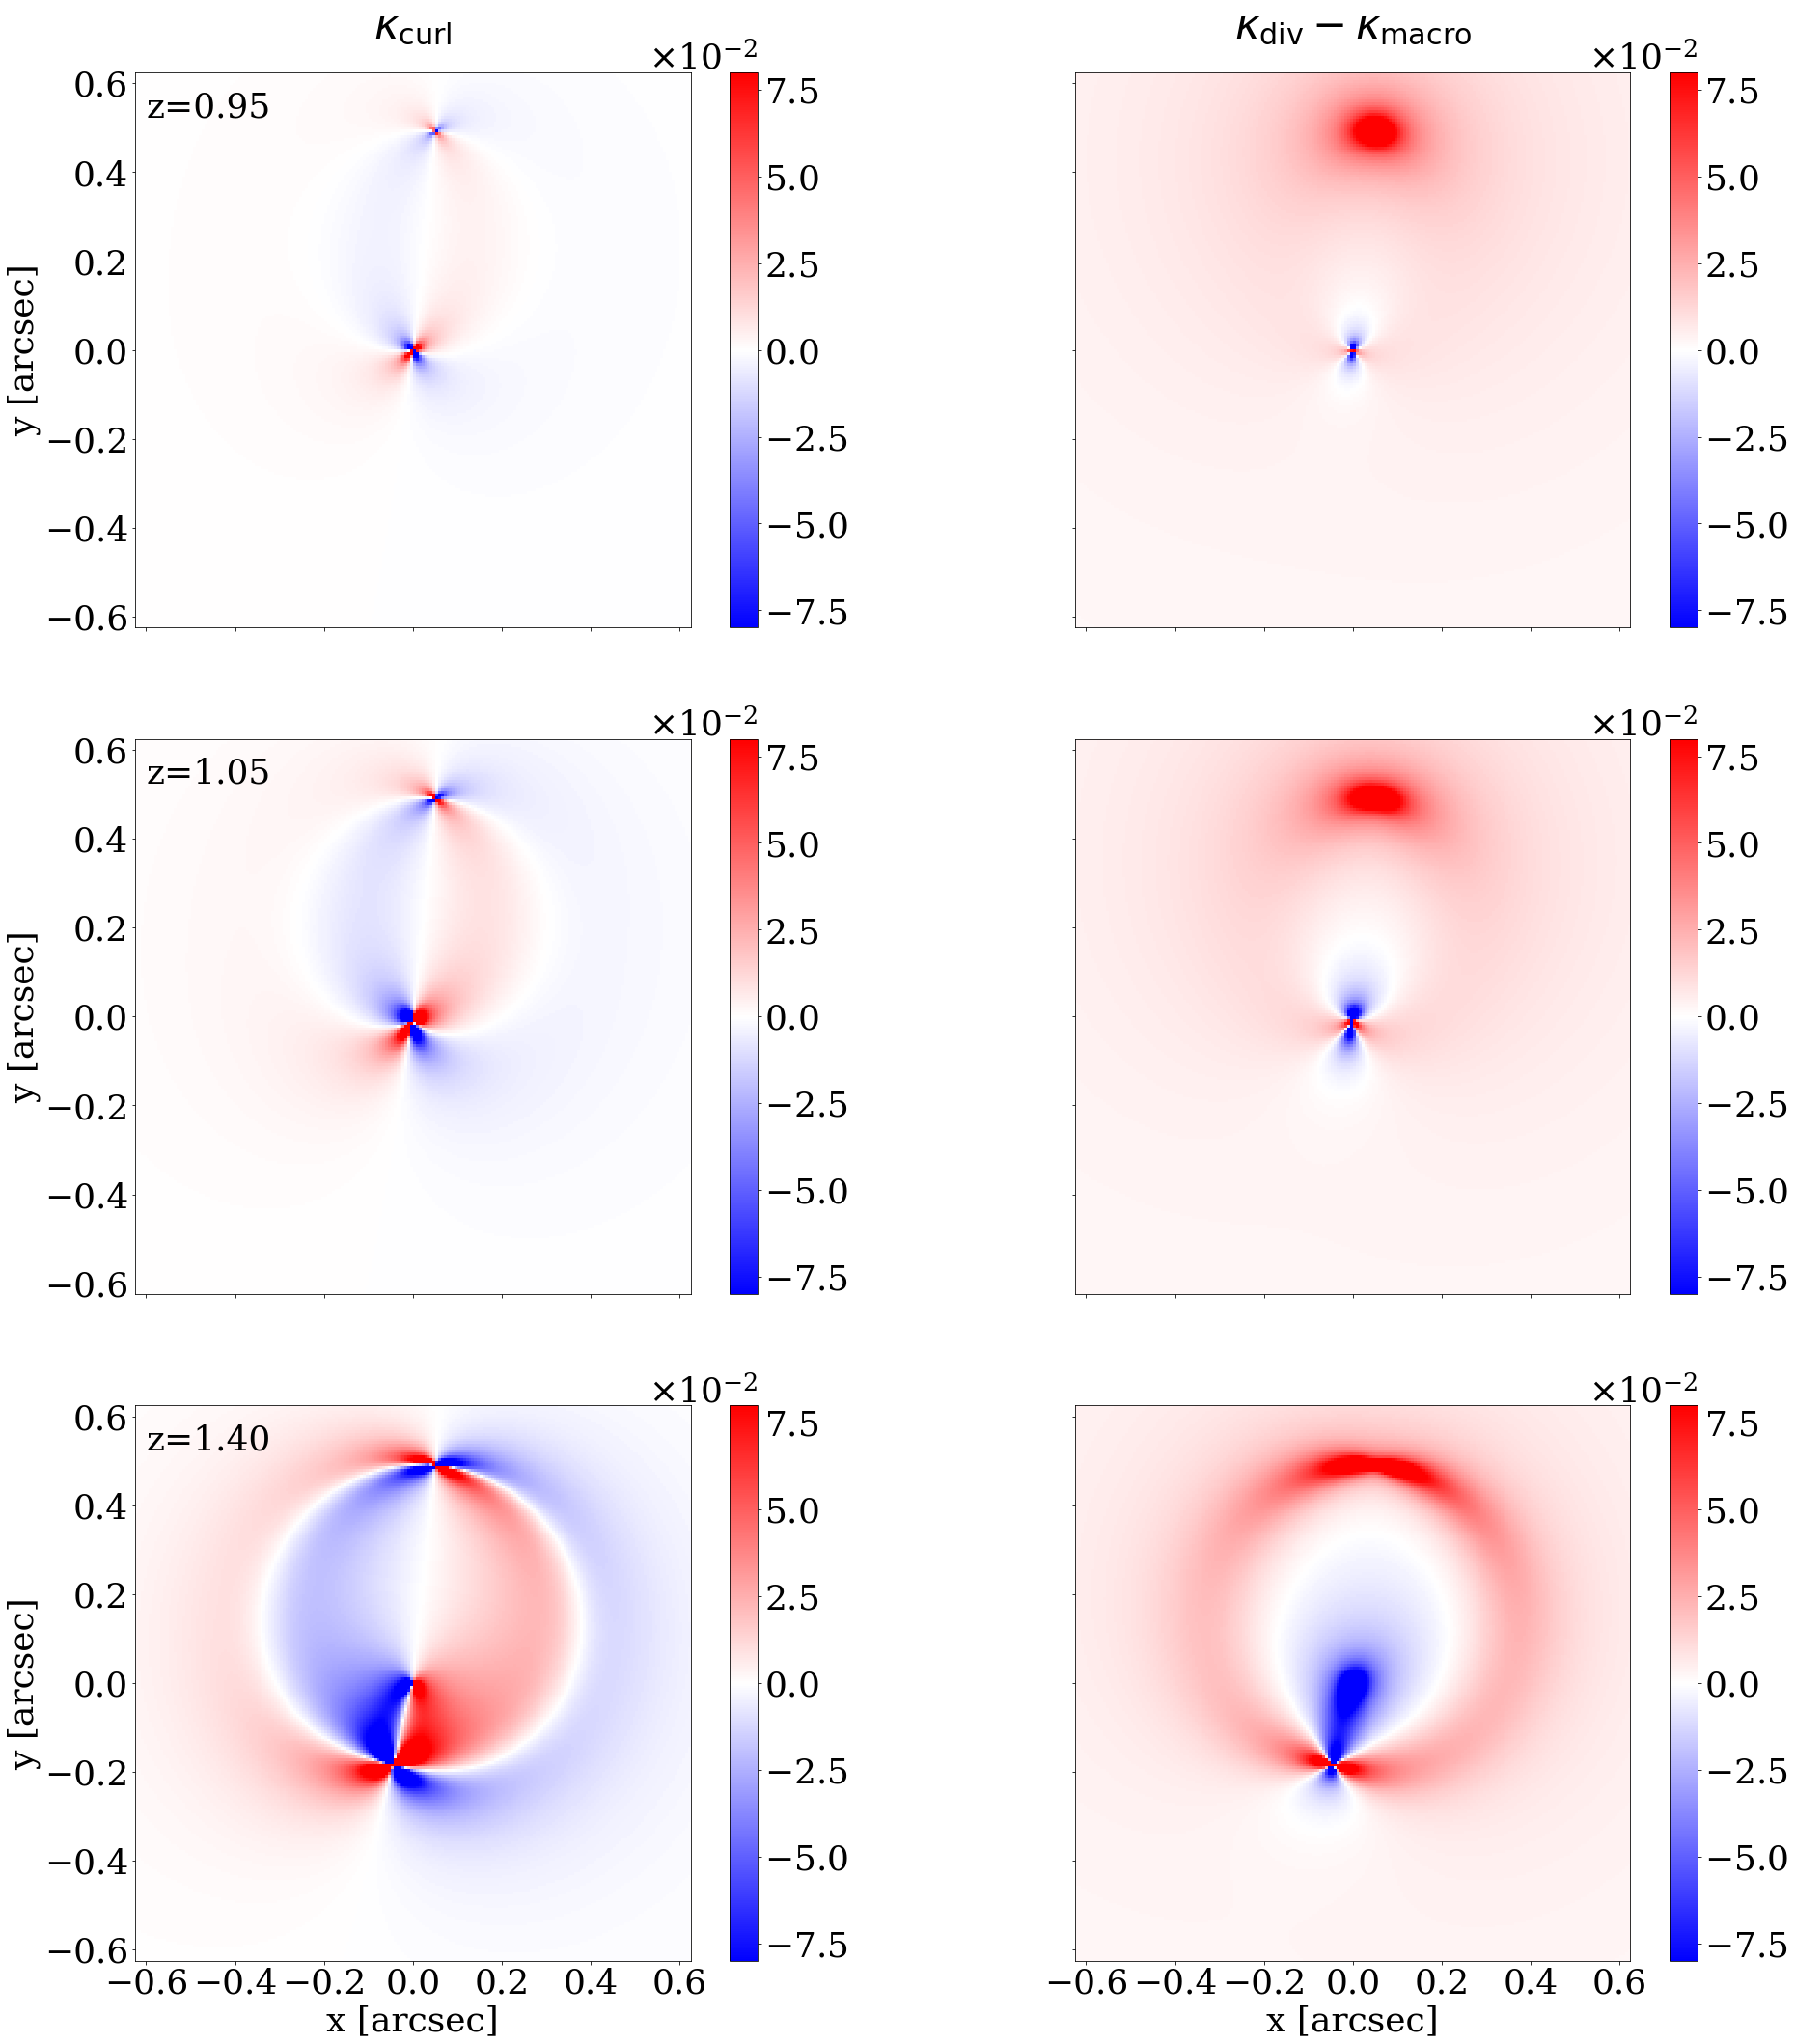

In [11]:
import matplotlib.ticker as ticker
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')
cmap.set_bad(color='magenta')

v_min = -0.08
v_max = 0.08

ext = numpix2*deltaPix2/2.

extent = [-ext,ext,-ext,ext]

f, axes = plt.subplots(3, 2, figsize=(32, 36), sharex=False, sharey=True)
ax = axes
ima = ax[0,0].matshow(curl_map3/2., origin='lower', vmin=v_min, vmax=v_max, cmap='bwr', extent=extent)

ax[0,0].set_title('$\kappa_\mathrm{curl}$')
ax[0,0].xaxis.set_ticks_position('bottom')
ax[0,0].autoscale(False)
ax[0,0].xaxis.set_ticklabels([])
#ax[0,0].set_ylabel('z=0.9,   y [arcsec]',rotation='horizontal',ha='right')
ax[0,0].set_ylabel('y [arcsec]')

cbar = f.colorbar(ima, ax=axes[0,0],format=OOMFormatter(-2, mathText=True))
imb = ax[0,1].matshow((kappa_map3 - macro_kap_map3)/2., origin='lower', vmin=-0.08, vmax=0.08, cmap='bwr', extent=extent)
ax[0,0].text(-0.6,0.525,'z=0.95')

ax[0,1].set_title('$\kappa_\mathrm{div} - \kappa_\mathrm{macro}$')
ax[0,1].xaxis.set_ticks_position('bottom')
ax[0,1].autoscale(False)
ax[0,1].xaxis.set_ticklabels([])
cbar2 = f.colorbar(imb, ax=axes[0,1],format=OOMFormatter(-2, mathText=True))

#################################################################

imc = ax[1,0].matshow(curl_map2/2., origin='lower', vmin=v_min, vmax=v_max, cmap='bwr', extent=extent)

ax[1,0].xaxis.set_ticks_position('bottom')
ax[1,0].xaxis.set_ticklabels([])
#ax[1,0].set_ylabel('z=1.0,   y [arcsec]',rotation='horizontal',ha='right')
ax[1,0].set_ylabel('y [arcsec]')

cbar = f.colorbar(imc, ax=axes[1,0],format=OOMFormatter(-2, mathText=True))
imd = ax[1,1].matshow((kappa_map2 - macro_kap_map2)/2., origin='lower', vmin=-0.08, vmax=0.08, cmap='bwr', extent=extent)
ax[1,0].text(-0.6,0.525,'z=1.05')

ax[1,1].xaxis.set_ticks_position('bottom')
ax[1,1].xaxis.set_ticklabels([])
cbar2 = f.colorbar(imd, ax=axes[1,1],format=OOMFormatter(-2, mathText=True))

############################################################333

ime = ax[2,0].matshow(curl_map/2., origin='lower', vmin=v_min, vmax=v_max, cmap='bwr', extent=extent)

ax[2,0].xaxis.set_ticks_position('bottom')

ax[2,0].set_xlabel('x [arcsec]')
#ax[2,0].set_ylabel('z=1.35,   y [arcsec]',rotation='horizontal',ha='right')
ax[2,0].set_ylabel('y [arcsec]')

cbar = f.colorbar(ime, ax=axes[2,0],format=OOMFormatter(-2, mathText=True))
imf = ax[2,1].matshow((kappa_map - macro_kap_map)/2., origin='lower', vmin=-0.08, vmax=0.08, cmap='bwr', extent=extent)
ax[2,0].text(-0.6,0.525,'z=1.40')

ax[2,1].xaxis.set_ticks_position('bottom')
ax[2,1].set_xlabel('x [arcsec]')
#ax[1,1].set_ylabel('y [arcsec]')
cbar2 = f.colorbar(imf, ax=axes[2,1],format=OOMFormatter(-2, mathText=True))


plt.show()